In [1]:
import pandas as pd
import numpy as np
import argparse
import random
import mlflow
from model import KGCN
from sklearn.preprocessing import LabelEncoder
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm import tqdm

/home/shane_wang/anaconda3/envs/KGCN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
### mlflow setting
remote_server_uri = "http://192.168.121.142:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("KGCN-PyTorch")    

<Experiment: artifact_location='file:///data/mlruns/33', experiment_id='33', lifecycle_stage='active', name='KGCN-PyTorch', tags={'mlflow.note.content': '[KGCN PyTorch '
                        'Version](https://github.com/zzaebok/KGCN-pytorch)\n'}>

In [4]:
# dataset_type = 'CMoney_stock_rel_stock_article'
# dataset_type = 'CMoney_stock_rel'
# dataset_type = 'CMoney_two_rel_stock_article'
# dataset_type = 'CMoney_two_rel'
dataset_type = 'CMoney_relabel_stock_rel_stock_article'
# dataset_type = 'CMoney_relabel_stock_rel'
# dataset_type = 'CMoney_relabel_two_rel_stock_article'
# dataset_type = 'CMoney_relabel_two_rel'

In [5]:
# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default=dataset_type, help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=3, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=2, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--l2_weight', type=float, default=2e-5, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-3, help='learning rate')
parser.add_argument('--train_data_ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args([])

In [6]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset(global_neg = True)
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,2616,23624,1
1,13463,43910,0
2,18558,62466,1
3,26764,47573,1
4,8489,14955,1
...,...,...,...
6689077,24136,14165,1
6689078,8311,44677,0
6689079,18022,18845,1
6689080,21302,59806,1


In [7]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

In [8]:
# train test split
x_train, x_test = train_test_split(df_dataset, test_size=1 - args.train_data_ratio, shuffle=False)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [9]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

device:  cuda


#### mlflow argument

In [10]:
run_name = "V1 : global neg sample"
description="random data splitting\nglobal negative sampling"
tags = {"data spliting": "random", "data version": "V3_relabel_stock_rel_stock_article", "data date": "0622-0705", "neg sample type": "all global", "neg sample num": "same as pos sample for each user (if enough)"}

In [ ]:
# train
train_loss_list = []
test_loss_list = []
train_auc_list = []
test_auc_list = []

with mlflow.start_run(run_name=run_name, description=description):
    ### log params
    params = vars(args)
    mlflow.log_params(params)

    ### log tags
    mlflow.set_tags(tags)

    for epoch in range(args.n_epochs):
        train_running_loss = 0.0
        train_total_roc = 0
        for user_ids, item_ids, labels in tqdm(train_loader):
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(user_ids, item_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()

            train_running_loss += loss.item()
            train_total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        
        # print train loss per every epoch
        train_loss, train_auc = train_running_loss / len(train_loader), train_total_roc / len(train_loader)
        print('[Epoch {}]train_loss: '.format(epoch+1), train_loss, ' ; train_auc: ', train_auc)
        train_loss_list.append(train_loss)
        train_auc_list.append(train_auc)
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_auc", train_auc, step=epoch)
            
        # evaluate per every epoch
        with torch.no_grad():
            test_running_loss = 0
            test_total_roc = 0
            for user_ids, item_ids, labels in tqdm(test_loader):
                user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
                outputs = net(user_ids, item_ids)
                test_running_loss += criterion(outputs, labels).item()
                test_total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            
            # print test loss per every epoch
            test_loss, test_auc = test_running_loss / len(test_loader), test_total_roc / len(test_loader)
            print('[Epoch {}]test_loss: '.format(epoch+1), test_loss, ' ; test_auc: ', test_auc)
            test_loss_list.append(test_loss)
            test_auc_list.append(test_auc)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_auc", test_auc, step=epoch)

    mlflow.pytorch.log_model(net, f"KGCN_epoch_{epoch+1}", registered_model_name=None)

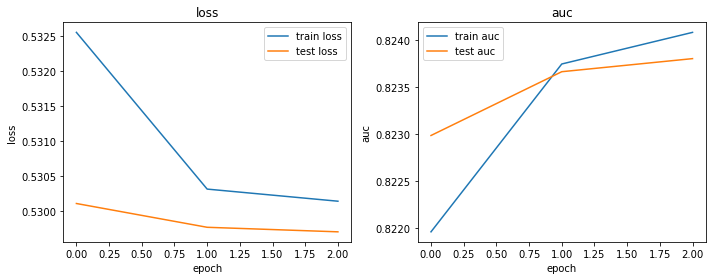

In [ ]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.set_title("loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(train_loss_list, label='train loss')
ax1.plot(test_loss_list, label='test loss')
ax1.legend()
ax2.set_title("auc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("auc")
ax2.plot(train_auc_list, label='train auc')
ax2.plot(test_auc_list, label='test auc')
ax2.legend()
plt.tight_layout()